A condiÃ§Ã£o de Feller foi satisfeita!


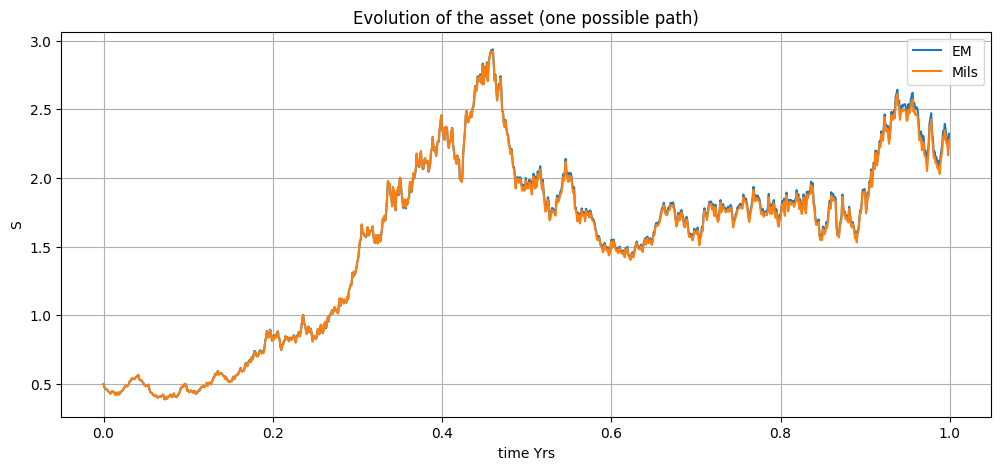

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Type
from scipy.stats import norm
from tqdm import tqdm
from ipynb.fs.full.ModelMethods import *

In [2]:
# Definindo alguns payoffs

call = lambda path, k : max(path[-1] - k, 0)
put = lambda path, k : max(k - path[-1], 0)
asian = lambda path, k : max(np.mean(path[-1]) - k, 0)

def call_barrier(path, low_barrier, high_barrier, k):
    
    for value in path:
        if low_barrier < value < high_barrier:
            continue
        else:
            return 0
        
    return max(path[-1] - k, 0)

## Black-Scholes Formula

In [3]:
def BS_formula(s0:float, K:float, r:float, T:float, sigma:float, t0:float=0):
    """A fórmula de black-scholes para calcular o preço de um call option.
    s0: valor inicial do ativo
    K: strike do contrato
    r: risk-free interest rate
    T: tempo até maturidade
    sigma: volatilidade do ativo
    t0: tempo inicial"""
    
    d1 = (np.log(s0/K) + (r + 0.5 * sigma**2)*(T-t0)) / (sigma * np.sqrt(T - t0))
    d2 = d1 - sigma * np.sqrt(T - t0)
    
    price = norm.cdf(d1) * s0 - norm.cdf(d2) * K * np.exp(-r*(T-t0))
    
    return price

## Precificação

In [4]:
# Função que precifica uma opção dada o seu payoff

def call_price_heston(model:Type[HestonModel], payoff,
                      K:float, N:int, t0:float=0,
                      T:float=1, s0:float=1, v0:float=0.5,
                      rho:float=0.2, nsim:int=1000, method=Euler_Maruyama):
  """Sets price in a european call option using heston model.
  Model: model of the evolution of the asset
  K: Strike
  N: Quantidade de passos
  t0: tempo inicial
  T: Time to maturity
  s0: valor inicial do ativo
  v0: valor inicial da volatilidade
  rho: correlação do ativo e da vol
  nsim: numbers of monte carlo simulations
  opt_type: europeu ou asiático.
  method: Método para aproximar a SDE"""

  paths = []
  prices = []

  dt = T/N
  for _ in range(nsim):
    dws = dW(dt=dt, T=T, rho=rho)

    _, path, _ = method(model=model, dt=dt, t0=t0, s0=s0, v0=v0, dWs_inc=dws)
    paths.append(path)

    prices.append(payoff(path, K))
  
  price = np.mean(prices)*np.exp(-model.mu*T)

  return price, paths

#### Precifica um call europeu e T = 0.01 anos.

In [5]:
call_params = {
    'S_0': 0.9,
    'Strike': 0.85,
    'T': 0.01,
    'r': 0.05,
    'kappa': 2,
    'theta': 0.04,
    'v': 0.04,
    'vol_of_vol': 0.3,
    'rho': -0.3,
    'payoff': call
}


Heston_obj = HestonModel(mu=call_params['r'], theta=call_params['theta'],
                         kappa=call_params['kappa'], qsi=call_params['vol_of_vol'])

price_BS = BS_formula(s0=call_params['S_0'], K=call_params['Strike'],
            r=call_params['r'], T=call_params['T'], sigma=call_params['theta']**0.5)

price_EM, paths_EM = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Euler_Maruyama)

price_MILS, paths_MILS = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Milstein)

print(f'Call price with Black-Scholes: {price_BS :^16f}')
print(f'Call price with Euler Maruyama: {price_EM :^16f}')
print(f'Call price with Milstein: {price_MILS :^16f}')

Call price with Black-Scholes:     0.050435    
Call price with Euler Maruyama:     0.050663    
Call price with Milstein:     0.050659    


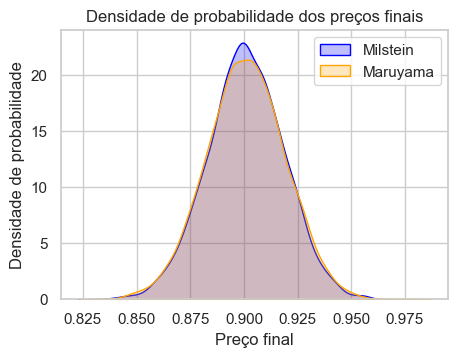

In [6]:
last_elements_maruyama = [sublist[-1] for sublist in paths_EM]
last_elements_milstein = [sublist[-1] for sublist in paths_MILS]
sns.set(style="whitegrid")

plt.figure(figsize=(5, 3.5))
sns.kdeplot(last_elements_milstein, fill=True, color='blue', label = 'Milstein')
sns.kdeplot(last_elements_maruyama, fill=True, color='orange', label = 'Maruyama')
plt.title('Densidade de probabilidade dos preços finais')
plt.xlabel('Preço final')
plt.ylabel('Densidade de probabilidade')
plt.legend()
plt.show()

#### Precifica um call europeu e T = 0.5 anos.

In [7]:
call_params = {
    'S_0': 0.9,
    'Strike': 0.85,
    'T': 0.5,
    'r': 0.05,
    'kappa': 2,
    'theta': 0.04,
    'v': 0.04,
    'vol_of_vol': 0.3,
    'rho': -0.3,
    'payoff': call
}

Heston_obj = HestonModel(mu=call_params['r'], theta=call_params['theta'],
                         kappa=call_params['kappa'], qsi=call_params['vol_of_vol'])

price_BS = BS_formula(s0=call_params['S_0'], K=call_params['Strike'],
            r=call_params['r'], T=call_params['T'], sigma=call_params['theta']**0.5)

price_EM, paths_EM = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Euler_Maruyama)

price_MILS, paths_MILS = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Milstein)

print(f'Call price with Black-Scholes: {price_BS :^16f}')
print(f'Call price with Euler Maruyama: {price_EM :^16f}')
print(f'Call price with Milstein: {price_MILS :^16f}')

Call price with Black-Scholes:     0.092208    
Call price with Euler Maruyama:     0.092913    
Call price with Milstein:     0.091576    


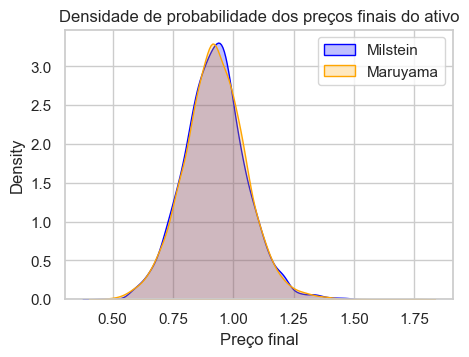

In [8]:
last_elements_maruyama = [sublist[-1] for sublist in paths_EM]
last_elements_milstein = [sublist[-1] for sublist in paths_MILS]
sns.set(style="whitegrid")

plt.figure(figsize=(5, 3.5))
sns.kdeplot(last_elements_milstein, fill=True, color='blue', label = 'Milstein')
sns.kdeplot(last_elements_maruyama, fill=True, color='orange', label = 'Maruyama')
plt.title('Densidade de probabilidade dos preços finais do ativo')
plt.xlabel('Preço final')
plt.legend()
plt.show()

#### Precifica um call asiático e T = 0.01 anos.

In [9]:
call_params = {
    'S_0': 0.9,
    'Strike': 0.85,
    'T': 0.01,
    'r': 0.05,
    'kappa': 2,
    'theta': 0.04,
    'v': 0.04,
    'vol_of_vol': 0.3,
    'rho': -0.3,
    'payoff': asian
}

Heston_obj = HestonModel(mu=call_params['r'], theta=call_params['theta'],
                         kappa=call_params['kappa'], qsi=call_params['vol_of_vol'])

price_EM, paths_EM = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Euler_Maruyama)

price_MILS, paths_MILS = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Milstein)

print(f'Asian option price with Euler Maruyama: {price_EM :^16f}')
print(f'Asian option price with Milstein: {price_MILS :^16f}')

Asian option price with Euler Maruyama:     0.050263    
Asian option price with Milstein:     0.050478    


#### Precifica um call asiático e T = 0.5 anos.

In [10]:
call_params = {
    'S_0': 0.9,
    'Strike': 0.85,
    'T': 0.5,
    'r': 0.05,
    'kappa': 2,
    'theta': 0.04,
    'v': 0.04,
    'vol_of_vol': 0.3,
    'rho': -0.3,
    'payoff': asian
}

Heston_obj = HestonModel(mu=call_params['r'], theta=call_params['theta'],
                         kappa=call_params['kappa'], qsi=call_params['vol_of_vol'])

price_EM, paths_EM = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Euler_Maruyama)

price_MILS, paths_MILS = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Milstein)

print(f'Asian option price with Euler Maruyama: {price_EM :^16f}')
print(f'Asian option price with Milstein: {price_MILS :^16f}')

Asian option price with Euler Maruyama:     0.093469    
Asian option price with Milstein:     0.089869    


#### Precifica um put e T = 0.01 anos.

In [11]:
call_params = {
    'S_0': 0.9,
    'Strike': 0.85,
    'T': 0.01,
    'r': 0.05,
    'kappa': 2,
    'theta': 0.04,
    'v': 0.04,
    'vol_of_vol': 0.3,
    'rho': -0.3,
    'payoff': put
}


Heston_obj = HestonModel(mu=call_params['r'], theta=call_params['theta'],
                         kappa=call_params['kappa'], qsi=call_params['vol_of_vol'])

price_BS = BS_formula(s0=call_params['S_0'], K=call_params['Strike'],
            r=call_params['r'], T=call_params['T'], sigma=call_params['theta']**0.5)

price_EM, paths_EM = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Euler_Maruyama)

price_MILS, paths_MILS = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Milstein)

print(f'Put price with Euler Maruyama: {price_EM :^16f}')
print(f'Put price with Milstein: {price_MILS :^16f}')

Put price with Euler Maruyama:     0.000019    
Put price with Milstein:     0.000012    


#### Precifica um put e T = 0.5 anos.

In [12]:
call_params = {
    'S_0': 0.9,
    'Strike': 0.85,
    'T': 0.5,
    'r': 0.05,
    'kappa': 2,
    'theta': 0.04,
    'v': 0.04,
    'vol_of_vol': 0.3,
    'rho': -0.3,
    'payoff': put
}


Heston_obj = HestonModel(mu=call_params['r'], theta=call_params['theta'],
                         kappa=call_params['kappa'], qsi=call_params['vol_of_vol'])

price_BS = BS_formula(s0=call_params['S_0'], K=call_params['Strike'],
            r=call_params['r'], T=call_params['T'], sigma=call_params['theta']**0.5)

price_EM, paths_EM = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Euler_Maruyama)

price_MILS, paths_MILS = call_price_heston(
                        model=Heston_obj, K=call_params['Strike'], N=1000,
                        t0=0, T=call_params['T'], s0=call_params['S_0'],
                        v0=call_params['v'], rho=call_params['rho'],
                        payoff=call_params['payoff'], nsim=5000,
                        method=Milstein)

print(f'Put price with Euler Maruyama: {price_EM :^16f}')
print(f'Put price with Milstein: {price_MILS :^16f}')

Call price with Euler Maruyama:     0.021439    
Call price with Milstein:     0.020813    
